In [70]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [71]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0590_FO_IMA_07018916_FORF253_CAL_0142-0161_Field_E.fits'

#Name of field
field='FieldE'

#wavelength of data
wavelength=25.2

In [72]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

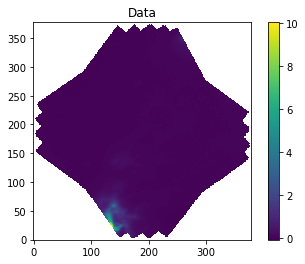

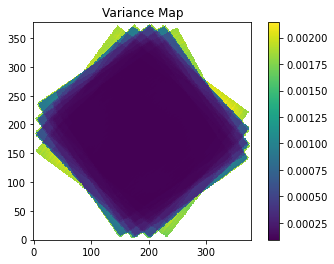

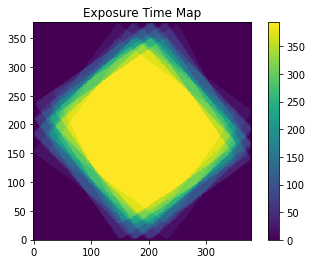

In [73]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

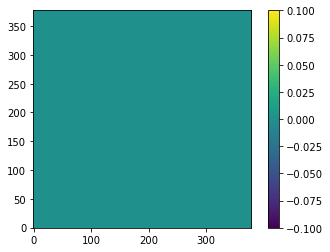

In [74]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
#mask2[350:380,0:370]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [75]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

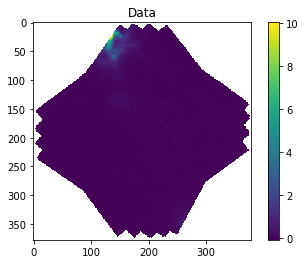

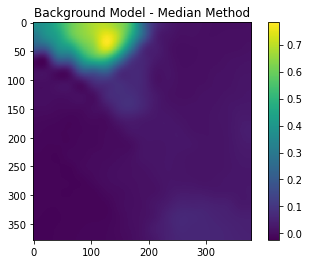

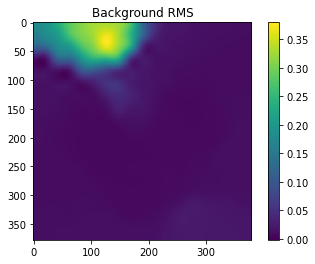

In [76]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [77]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

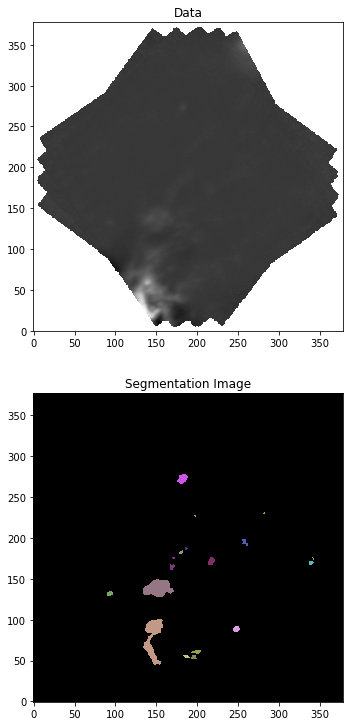

In [78]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [79]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,144.66863444098075,64.42904988503527,"266.4164321661646,-28.998559330337795",0.0012799760236837131,0.23448024281106647,142.5639876291284,608.0,13.960239861989592,4.682500561464939,-87.27677120394688,0.04551697552090268,0.0038419147146737296,0.005222515020690188,0.9420697927261144,0.664583086841203,2.981364268672309,24.518082145305733,nan,nan,nan,356.5507120773068,nan
2,195.955374646434,54.2786080898491,"266.40392275480303,-29.000725536499157",-0.011124050249063783,0.05209904712406174,1.0940799896052966,21.0,1.6805188431065272,1.0591404047538358,12.314526545107864,0.3785324702464988,-0.22393704007889378,0.866998838569548,0.7763954437046204,0.36975392504617255,1.5866818370479516,3.307630387129734,21.03305023646731,nan,3.7375837552203497,1.2133169810839999,nan
3,187.0706759712185,55.37133310812682,"266.406089875983,-29.000492369845148",-0.011003845865472987,0.07564298906500631,1.6641457594301388,22.0,1.8476693750508861,0.9299129934225687,-18.338697579633656,0.37840302579982094,0.5157747806206967,1.0709380269041584,0.8641177365643101,0.4967102848706586,1.9869271513784224,3.444249464863349,27.89174822814711,nan,3.780139034675271,2.2148486160371617,nan
4,199.46386305667014,61.10033562739101,"266.4030669557187,-28.99927024599852",-0.011092517506606666,0.04791298101066835,2.0123452024480706,42.0,2.7726905949549567,1.2037002379085897,7.108519545192755,0.13865335828692538,-0.13755948603624116,0.6816041333663594,0.9008516117391763,0.5658728600663991,2.303472665065235,5.033123472592051,30.037222834059655,nan,3.5426776873169015,3.23831982892543,nan
5,248.3290430761656,88.88829132195059,"266.39114867300907,-28.993341739645846",-0.002105454859919677,0.012105249525034294,0.5447362286265433,45.0,1.9517829785658618,1.6372687861113866,37.29428852051687,0.3030864737192564,-0.1065646362864532,0.3324621236679994,0.5443502901678006,0.1611419896107379,1.1920968597962864,4.241980003573166,5.978594047620181,nan,2.7570496482847733,2.1537973883335058,nan
6,151.7643096258172,138.11988793142922,"266.4146994792553,-28.982838797505668",0.04575338667717384,0.08120596067356267,44.90689625248016,553.0,8.712024255237655,4.730570355568505,6.945578316603729,0.013636130272159314,-0.00756506006278079,0.04422536529767685,0.8397370609655719,0.457006751017194,1.8416435229596477,16.50707541423275,132.72839852849864,nan,1.5799387802476628,84.98708651557862,nan
7,93.56295883643554,132.345796013264,"266.4288936579359,-28.984068499787284",0.13028584607985821,0.003645393329696514,0.13852494652846753,38.0,1.9894965033716823,1.2471859799219016,20.453877813182423,0.3003024339131182,-0.25554899884409754,0.5952355880531843,0.7791116120999237,0.37311476657121856,1.5951883162575833,3.909841403215324,3.9169009010220845,nan,2.311916972531757,2.072638438311425,nan
8,169.38117319300176,164.99553800854522,"266.41040268706774,-28.977105668644782",0.03851200254890378,0.046080416783131614,1.42849292027708,31.0,1.80286825418012,1.415128573782615,64.36702125776512,0.46347888461747766,-0.14953174631286423,0.3435354271396005,0.6195822084302056,0.21506822780782464,1.2739960789294809,3.8163064048647923,11.721083512401021,nan,3.3728917563120877,1.8129377124929815,nan


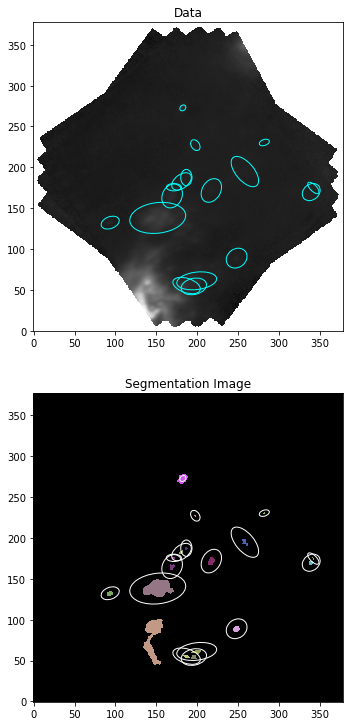

In [80]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

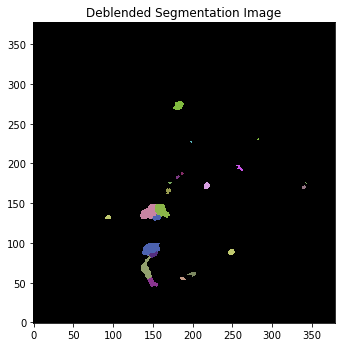

In [81]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [82]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,195.955374646434,54.2786080898491,"266.40392275480303,-29.000725536499157",-0.011124050249063783,0.05209904712406174,1.0940799896052966,21.0,1.6805188431065272,1.0591404047538358,12.314526545107864,0.3785324702464988,-0.22393704007889378,0.866998838569548,0.7763954437046204,0.36975392504617255,1.5866818370479516,3.307630387129734,21.03305023646731,nan,3.7375837552203497,1.2133169810839999,nan
2,187.0706759712185,55.37133310812682,"266.406089875983,-29.000492369845148",-0.011003845865472987,0.07564298906500631,1.6641457594301388,22.0,1.8476693750508861,0.9299129934225687,-18.338697579633656,0.37840302579982094,0.5157747806206967,1.0709380269041584,0.8641177365643101,0.4967102848706586,1.9869271513784224,3.444249464863349,27.89174822814711,nan,3.780139034675271,2.2148486160371617,nan
3,199.46386305667014,61.10033562739101,"266.4030669557187,-28.99927024599852",-0.011092517506606666,0.04791298101066835,2.0123452024480706,42.0,2.7726905949549567,1.2037002379085897,7.108519545192755,0.13865335828692538,-0.13755948603624116,0.6816041333663594,0.9008516117391763,0.5658728600663991,2.303472665065235,5.033123472592051,30.037222834059655,nan,3.5426776873169015,3.23831982892543,nan
4,248.3290430761656,88.88829132195059,"266.39114867300907,-28.993341739645846",-0.002105454859919677,0.012105249525034294,0.5447362286265433,45.0,1.9517829785658618,1.6372687861113866,37.29428852051687,0.3030864737192564,-0.1065646362864532,0.3324621236679994,0.5443502901678006,0.1611419896107379,1.1920968597962864,4.241980003573166,5.978594047620181,nan,2.7570496482847733,2.1537973883335058,nan
5,93.56295883643554,132.345796013264,"266.4288936579359,-28.984068499787284",0.13028584607985821,0.003645393329696514,0.13852494652846753,38.0,1.9894965033716823,1.2471859799219016,20.453877813182423,0.3003024339131182,-0.25554899884409754,0.5952355880531843,0.7791116120999237,0.37311476657121856,1.5951883162575833,3.909841403215324,3.9169009010220845,nan,2.311916972531757,2.072638438311425,nan
6,169.38117319300176,164.99553800854522,"266.41040268706774,-28.977105668644782",0.03851200254890378,0.046080416783131614,1.42849292027708,31.0,1.80286825418012,1.415128573782615,64.36702125776512,0.46347888461747766,-0.14953174631286423,0.3435354271396005,0.6195822084302056,0.21506822780782464,1.2739960789294809,3.8163064048647923,11.721083512401021,nan,3.3728917563120877,1.8129377124929815,nan
7,217.38615845004009,171.683699089241,"266.39869615969127,-28.975679102411135",0.007147255965983479,0.026543993392917332,1.513007623396288,57.0,2.466347156829641,1.7854250910496963,59.0638627277035,0.2742430514324641,-0.1316723210721573,0.20385467643659622,0.6898894342175099,0.2760852477293725,1.381378120646671,5.069870970340643,4.9190924405959935,nan,2.5093087195837174,1.869386202402939,nan
8,339.6063134052959,169.754192957274,"266.36889164809946,-28.97608676941903",0.007412855199754579,0.024960557528708047,0.42432947798803683,17.0,1.2947808550344468,1.0286736408350974,40.083325631822916,0.741000357238905,-0.3434119150090611,0.8005237604127822,0.6072942102895186,0.2055229756948096,1.2586896403637975,2.7535424026566853,6.894740621906492,nan,3.6720143183694836,0.6539638865070022,nan


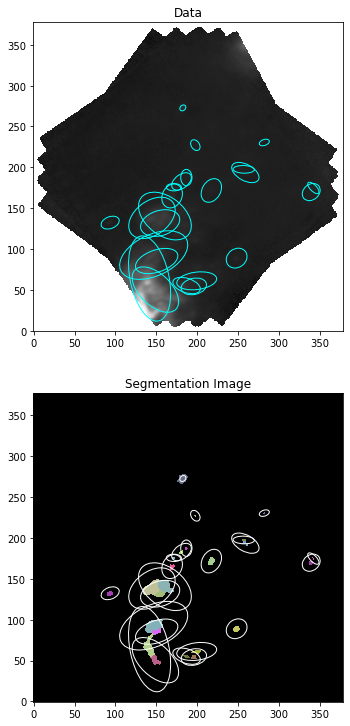

In [83]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [84]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [85]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [86]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,195.955374646434,54.2786080898491,"266.40392275480303,-29.000725536499157",-0.011124050249063783,0.05209904712406174,1.0940799896052966,21.0,1.6805188431065272,1.0591404047538358,12.314526545107864,0.3785324702464988,-0.22393704007889378,0.866998838569548,0.7763954437046204,0.36975392504617255,1.5866818370479516,3.307630387129734,21.03305023646731,0.2350921063506772,3.7375837552203497,1.2133169810839999,0.04864894,0.052234853984482695,0.05176279456829978,0.003592017465639564,1.138540944090054
2,187.0706759712185,55.37133310812682,"266.406089875983,-29.000492369845148",-0.011003845865472987,0.07564298906500631,1.6641457594301388,22.0,1.8476693750508861,0.9299129934225687,-18.338697579633656,0.37840302579982094,0.5157747806206967,1.0709380269041584,0.8641177365643101,0.4967102848706586,1.9869271513784224,3.444249464863349,27.89174822814711,0.22713661951070924,3.780139034675271,2.2148486160371617,0.047814723,0.07528391269467016,0.07440661424451618,0.009013652103334052,1.7063770280627544
3,199.46386305667014,61.10033562739101,"266.4030669557187,-28.99927024599852",-0.011092517506606666,0.04791298101066835,2.0123452024480706,42.0,2.7726905949549567,1.2037002379085897,7.108519545192755,0.13865335828692538,-0.13755948603624116,0.6816041333663594,0.9008516117391763,0.5658728600663991,2.303472665065235,5.033123472592051,30.037222834059655,0.29503913242499286,3.5426776873169015,3.23831982892543,0.066237375,0.049448147947489585,0.04899990482255297,0.004865592895455549,2.221869896467102
4,248.3290430761656,88.88829132195059,"266.39114867300907,-28.993341739645846",-0.002105454859919677,0.012105249525034294,0.5447362286265433,45.0,1.9517829785658618,1.6372687861113866,37.29428852051687,0.3030864737192564,-0.1065646362864532,0.3324621236679994,0.5443502901678006,0.1611419896107379,1.1920968597962864,4.241980003573166,5.978594047620181,0.23355198744326175,2.7570496482847733,2.1537973883335058,0.071971886,0.012085883168442753,0.012004833450116218,0.0011193227194756545,2.7527194176222256
5,93.56295883643554,132.345796013264,"266.4288936579359,-28.984068499787284",0.13028584607985821,0.003645393329696514,0.13852494652846753,38.0,1.9894965033716823,1.2471859799219016,20.453877813182423,0.3003024339131182,-0.25554899884409754,0.5952355880531843,0.7791116120999237,0.37311476657121856,1.5951883162575833,3.909841403215324,3.9169009010220845,0.18463019721590704,2.311916972531757,2.072638438311425,0.07028115,0.0037736356000118566,0.0036282481538237243,0.001227436121539644,4.5428726757883515
6,169.38117319300176,164.99553800854522,"266.41040268706774,-28.977105668644782",0.03851200254890378,0.046080416783131614,1.42849292027708,31.0,1.80286825418012,1.415128573782615,64.36702125776512,0.46347888461747766,-0.14953174631286423,0.3435354271396005,0.6195822084302056,0.21506822780782464,1.2739960789294809,3.8163064048647923,11.721083512401021,0.22880519287087372,3.3728917563120877,1.8129377124929815,0.05340733,0.04617998564636169,0.046050087688033856,0.004053315978918251,1.489742514149295
7,217.38615845004009,171.683699089241,"266.39869615969127,-28.975679102411135",0.007147255965983479,0.026543993392917332,1.513007623396288,57.0,2.466347156829641,1.7854250910496963,59.0638627277035,0.2742430514324641,-0.1316723210721573,0.20385467643659622,0.6898894342175099,0.2760852477293725,1.381378120646671,5.069870970340643,4.9190924405959935,0.22461041554520236,2.50930871

In [87]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [88]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,195.95537464634654,54.27860808988089,"266.40392275480303,-29.000725536499157",1.2191379497135273,0.04896633690808962,4.305097134362405,0.09767445942791896,9.72113518997971,0.14604448287903285,16.74916418611612,0.19487833429993323,24.340076485484545,0.24464128617536224
2,187.0706759712406,55.3713331081415,"266.406089875983,-29.000492369845148",2.1783509084592287,0.046950638299638615,7.707417251668208,0.09455026397953696,15.031123648503616,0.14228942290962568,23.804140372616658,0.1903467602130526,34.041497230971586,0.239815337735091
3,199.46386305659254,61.10033562731675,"266.4030669557187,-28.99927024599852",1.7372056079333895,0.04735135670816476,5.3440409454007165,0.09374412827614095,9.998127223545984,0.14064690226356658,15.899511168277757,0.18843725838732545,21.713110415821294,0.23664084732908575
4,248.32904307622024,88.88829132186272,"266.39114867300907,-28.993341739645846",1.1934421532915405,0.04941745725804828,3.2427695046863563,0.0990979246194306,4.766085011644565,0.1480078596690701,5.55299961611698,0.19721438958680537,6.057980826788119,0.24783526653846583
5,93.56295883646642,132.34579601331896,"266.4288936579359,-28.984068499787284",1.3517973395646266,0.05255011694195869,3.0254470253258976,0.10554528012157405,3.913455862367443,0.15849526911292777,4.070960945873308,0.2115127949117842,4.070467916751705,0.2650183261768019
6,169.38117319306696,164.99553800863185,"266.41040268706774,-28.977105668644782",1.2886728134738472,0.044280465259705644,3.9575110835994596,0.08849055254749762,6.604822577379535,0.13262732186683873,8.687547545136072,0.17689930411638025,10.164837863560894,0.22115827912307628
7,217.3861584500629,171.68369908925754,"266.39869615969127,-28.975679102411135",0.7431620067387472,0.04432960032594801,2.525946543026009,0.0887231754071824,4.131233010651481,0.13316550435563415,4.773221412894001,0.1776462826912171,4.519552717500917,0.22213745955562153
8,339.60631340522826,169.75419295724907,"266.36889164809946,-28.97608676941903",0.7754307631667334,0.05522789888009684,2.345188379810417,0.11198676961098544,4.484457149931336,0.1716219937475537,6.665078257622045,0.23268622841615438,9.001423364896866,0.29689012282848887


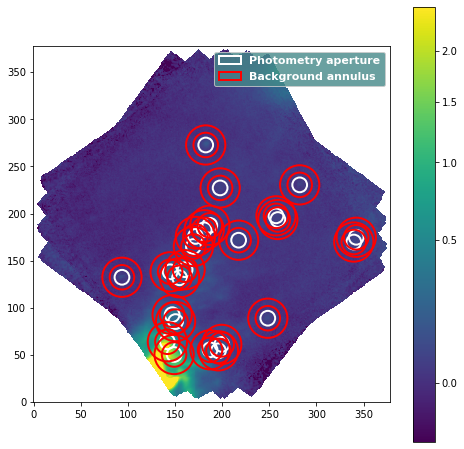

In [89]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [90]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [91]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-91-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,195.95537464634654,54.27860808988089,"266.40392275480303,-29.000725536499157",9.72113518997971,0.14604448287903285,0.005164611236896495,0.011326350875812546,8.730833405335867,0.14604448287903285,0.005164611236896494,7.3826459489800795
2,187.0706759712406,55.3713331081415,"266.406089875983,-29.000492369845148",15.031123648503616,0.14228942290962568,0.007146873123920788,0.013144290112716088,13.660727914033018,0.14228942290962568,0.007146873123920789,10.011778977470573
3,199.46386305659254,61.10033562731675,"266.4030669557187,-28.99927024599852",9.998127223545984,0.14064690226356658,0.006096718520281107,0.009885685797912235,8.829096108876133,0.14064690226356658,0.006096718520281107,6.9541757178030705
4,248.32904307622024,88.88829132186272,"266.39114867300907,-28.993341739645846",4.766085011644565,0.1480078596690701,-5.809946652980688e-05,-0.0009369811365716333,4.777225444632101,0.1480078596690701,0.0,11.192962079797322
5,93.56295883646642,132.34579601331896,"266.4288936579359,-28.984068499787284",3.913455862367443,0.15849526911292777,-0.0015775194796615725,-0.002454401871488432,4.21594142892057,0.15849526911292777,0.0,9.545487246446838
6,169.38117319306696,164.99553800863185,"266.41040268706774,-28.977105668644782",6.604822577379535,0.13262732186683873,8.651038078483994e-05,0.003978514216858857,6.58823441990712,0.13262732186683873,8.651038078483994e-05,15.37353671250286
7,217.3861584500629,171.68369908925754,"266.39869615969127,-28.975679102411135",4.131233010651481,0.13316550435563415,-0.0023216496259713605,-0.0035900227524037296,4.57640374325027,0.13316550435563415,0.0,11.304208203307242
8,339.60631340522826,169.75419295724907,"266.36889164809946,-28.97608676941903",4.484457149931336,0.1716219937475537,0.006605798870345795,0.008239308194533172,3.217811102390153,0.1716219937475537,0.006605798870345793,2.418534658716384


In [92]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [93]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,195.955374646434,54.2786080898491,"266.40392275480303,-29.000725536499157",-0.011124050249063783,0.05209904712406174,1.0940799896052966,21.0,1.6805188431065272,1.0591404047538358,12.314526545107864,0.3785324702464988,-0.22393704007889378,0.866998838569548,0.7763954437046204,0.36975392504617255,1.5866818370479516,3.307630387129734,21.03305023646731,0.2350921063506772,3.7375837552203497,1.2133169810839999,0.04864894,0.052234853984482695,0.05176279456829978,0.003592017465639564,1.138540944090054,1.2191379497135273,0.04896633690808962,4.305097134362405,0.09767445942791896,9.72113518997971,0.14604448287903285,16.74916418611612,0.19487833429993323,24.340076485484545,0.24464128617536224,0.005164611236896495,0.011326350875812546,8.730833405335867,0.14604448287903285,0.005164611236896494,7.3826459489800795,1.1091044180864336,3.86496300785403,14.98862768008262,21.5892381948072,2.746479492258626,5.019142795865336,9.025959430068228,9.737477182237678,9.737477182237678,C7FieldE,25.2
2,187.0706759712185,55.37133310812682,"266.406089875983,-29.000492369845148",-0.011003845865472987,0.07564298906500631,1.6641457594301388,22.0,1.8476693750508861,0.9299129934225687,-18.338697579633656,0.37840302579982094,0.5157747806206967,1.0709380269041584,0.8641177365643101,0.4967102848706586,1.9869271513784224,3.444249464863349,27.89174822814711,0.22713661951070924,3.780139034675271,2.2148486160371617,0.047814723,0.07528391269467016,0.07440661424451618,0.009013652103334052,1.7063770280627544,2.1783509084592287,0.046950638299638615,7.707417251668208,0.09455026397953696,15.031123648503616,0.14228942290962568,23.804140372616658,0.1903467602130526,34.041497230971586,0.239815337735091,0.007146873123920788,0.013144290112716088,13.660727914033018,0.14228942290962568,0.007146873123920789,10.011778977470573,2.0260847157402737,7.098352480792387,21.367881289113374,30.234842412997704,4.48225844868645,8.059128517705403,11.102351372023147,11.733075223870943,11.733075223870943,C7FieldE,25.2
3,199.46386305667014,61.10033562739101,"266.4030669557187,-28.99927024599852",-0.011092517506606666,0.04791298101066835,2.0123452024480706,42.0,2.7726905949549567,1.2037002379085897,7.108519545192755,0.13865335828692538,-0.13755948603624116,0.6816041333663594,0.9008516117391763,0.5658728600663991,2.303472665065235,5.033123472592051,30.037222834059655,0.29503913242499286,3.5426776873169015,3.23831982892543,0.066237375,0.049448147947489585,0.04899990482255297,0.004865592895455549,2.221869896467102,1.7372056079333895,0.04735135670816476,5.3440409454007165,0.09374412827614095,9.998127223545984,0.14064690226356658,15.899511168277757,0.18843725838732545,21.713110415821294,0.23664084732908575,0.006096718520281107,0.0098856857979122

In [94]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [95]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,195.955374646434,54.2786080898491,"266.40392275480303,-29.000725536499157",-0.011124050249063783,0.05209904712406174,1.0940799896052966,21.0,1.6805188431065272,1.0591404047538358,12.314526545107864,0.3785324702464988,-0.22393704007889378,0.866998838569548,0.7763954437046204,0.36975392504617255,1.5866818370479516,3.307630387129734,21.03305023646731,0.2350921063506772,3.7375837552203497,1.2133169810839999,0.04864894,0.052234853984482695,0.05176279456829978,0.003592017465639564,1.138540944090054,1.2191379497135273,0.04896633690808962,4.305097134362405,0.09767445942791896,9.72113518997971,0.14604448287903285,16.74916418611612,0.19487833429993323,24.340076485484545,0.24464128617536224,0.005164611236896495,0.011326350875812546,8.730833405335867,0.14604448287903285,0.005164611236896494,7.3826459489800795,1.1091044180864336,3.86496300785403,14.98862768008262,21.5892381948072,2.746479492258626,5.019142795865336,9.025959430068228,9.737477182237678,9.737477182237678,C7FieldE,25.2
2,187.0706759712185,55.37133310812682,"266.406089875983,-29.000492369845148",-0.011003845865472987,0.07564298906500631,1.6641457594301388,22.0,1.8476693750508861,0.9299129934225687,-18.338697579633656,0.37840302579982094,0.5157747806206967,1.0709380269041584,0.8641177365643101,0.4967102848706586,1.9869271513784224,3.444249464863349,27.89174822814711,0.22713661951070924,3.780139034675271,2.2148486160371617,0.047814723,0.07528391269467016,0.07440661424451618,0.009013652103334052,1.7063770280627544,2.1783509084592287,0.046950638299638615,7.707417251668208,0.09455026397953696,15.031123648503616,0.14228942290962568,23.804140372616658,0.1903467602130526,34.041497230971586,0.239815337735091,0.007146873123920788,0.013144290112716088,13.660727914033018,0.14228942290962568,0.007146873123920789,10.011778977470573,2.0260847157402737,7.098352480792387,21.367881289113374,30.234842412997704,4.48225844868645,8.059128517705403,11.102351372023147,11.733075223870943,11.733075223870943,C7FieldE,25.2
3,199.46386305667014,61.10033562739101,"266.4030669557187,-28.99927024599852",-0.011092517506606666,0.04791298101066835,2.0123452024480706,42.0,2.7726905949549567,1.2037002379085897,7.108519545192755,0.13865335828692538,-0.13755948603624116,0.6816041333663594,0.9008516117391763,0.5658728600663991,2.303472665065235,5.033123472592051,30.037222834059655,0.29503913242499286,3.5426776873169015,3.23831982892543,0.066237375,0.049448147947489585,0.04899990482255297,0.004865592895455549,2.221869896467102,1.7372056079333895,0.04735135670816476,5.3440409454007165,0.09374412827614095,9.998127223545984,0.14064690226356658,15.899511168277757,0.18843725838732545,21.713110415821294,0.23664084732908575,0.006096718520281107,0.0098856857979122

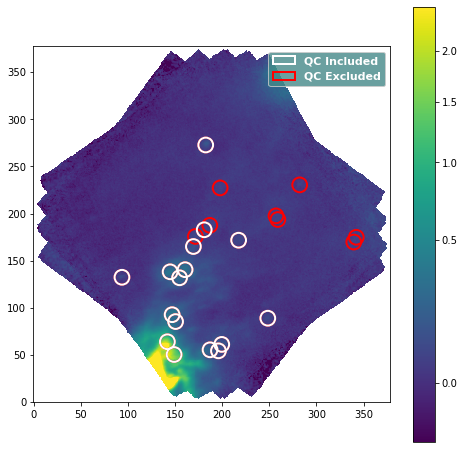

In [96]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

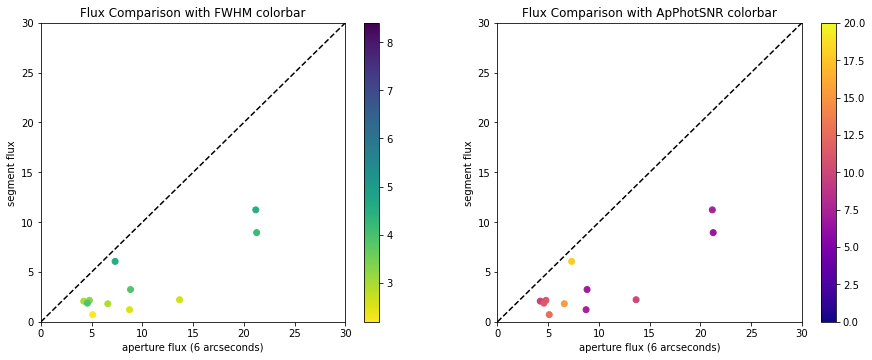

In [97]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

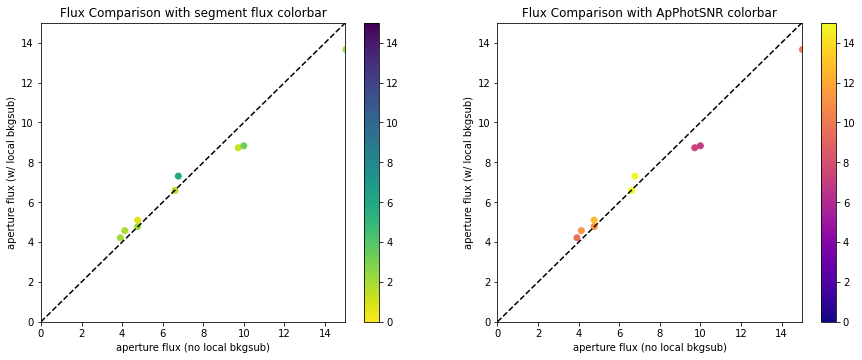

In [98]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [99]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)